In [1]:
import re
import math
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


# 1. Cleaning & Preprocessing

In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
human_fb = pd.DataFrame(df.groupby('Human Feedback')['Feedback ID'].count()).reset_index()
human_fb

,Human Feedback,Feedback ID
0,MATCH,996
1,NOT MATCH,966


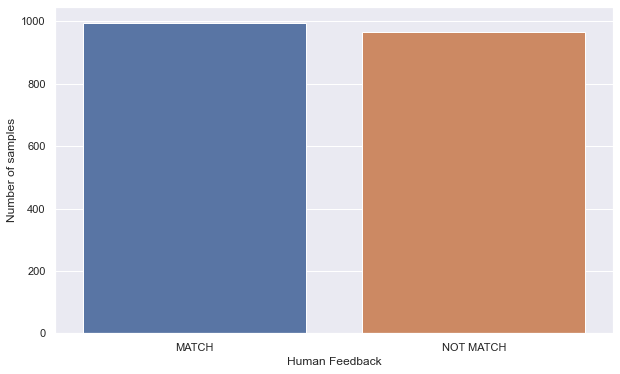

In [7]:
sb.set_theme()
plt.figure(figsize=(10, 6))
sb.barplot(data = human_fb, x = 'Human Feedback', y = 'Feedback ID')
plt.ylabel('Number of samples');

In [8]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


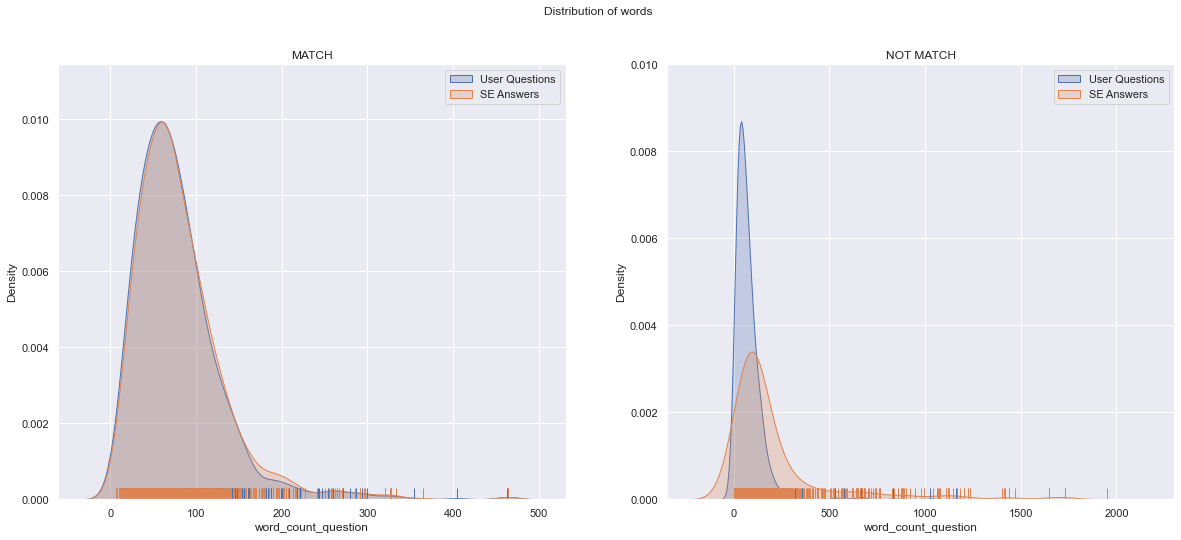

In [9]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_pos['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_pos['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.title('MATCH')
plt.legend()
plt.subplot(122)
sb.distplot(df_neg['word_count_lookup'], hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='User Questions')
sb.distplot(df_neg['word_count_question'],hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label='SE Answers')
plt.ylim([0, 0.01])
plt.title('NOT MATCH')
plt.legend()
plt.suptitle('Distribution of words');

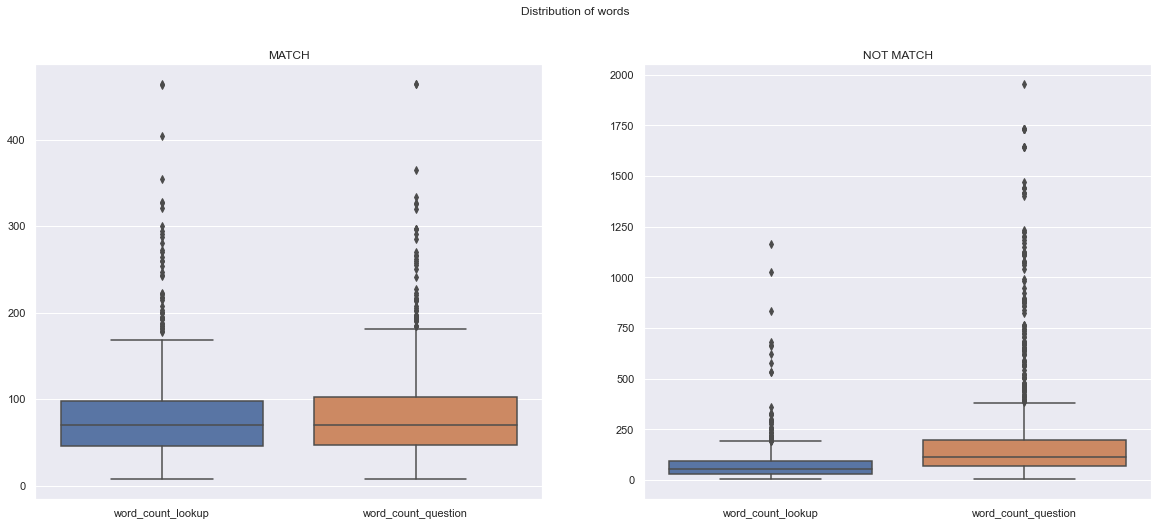

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_pos[['word_count_lookup', 'word_count_question']])
plt.title('MATCH')
plt.subplot(122)
sb.boxplot(data = df_neg[['word_count_lookup', 'word_count_question']])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words');

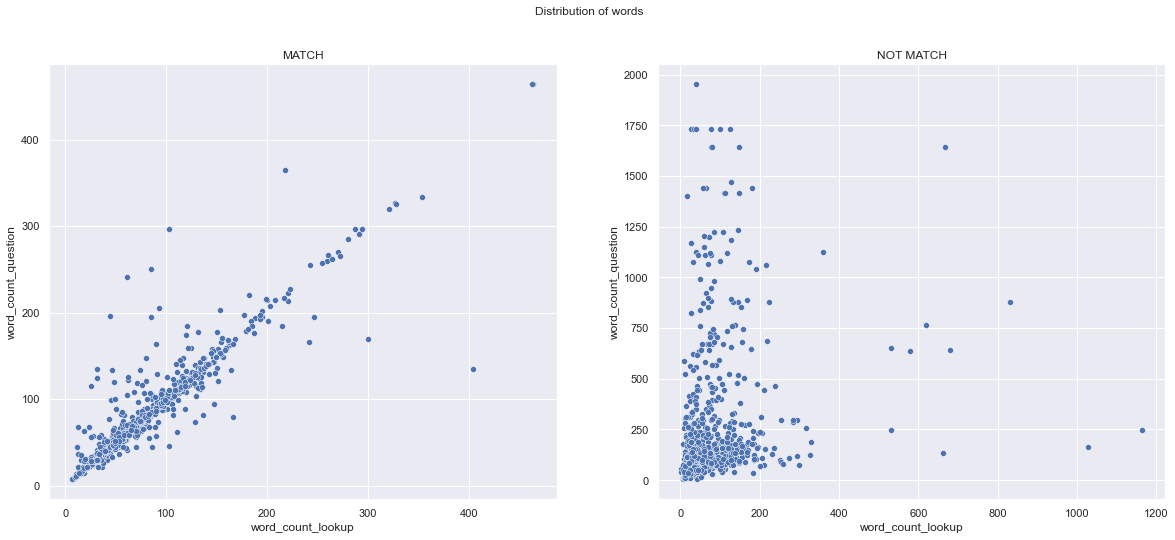

In [11]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.scatterplot(data = df_pos, x = df_pos['word_count_lookup'], y = df_pos['word_count_question'])
plt.title('MATCH')
plt.subplot(122)
sb.scatterplot(data = df_neg, x = df_neg['word_count_lookup'], y = df_neg['word_count_question'])
plt.title('NOT MATCH')
plt.suptitle('Distribution of words');

In [12]:
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

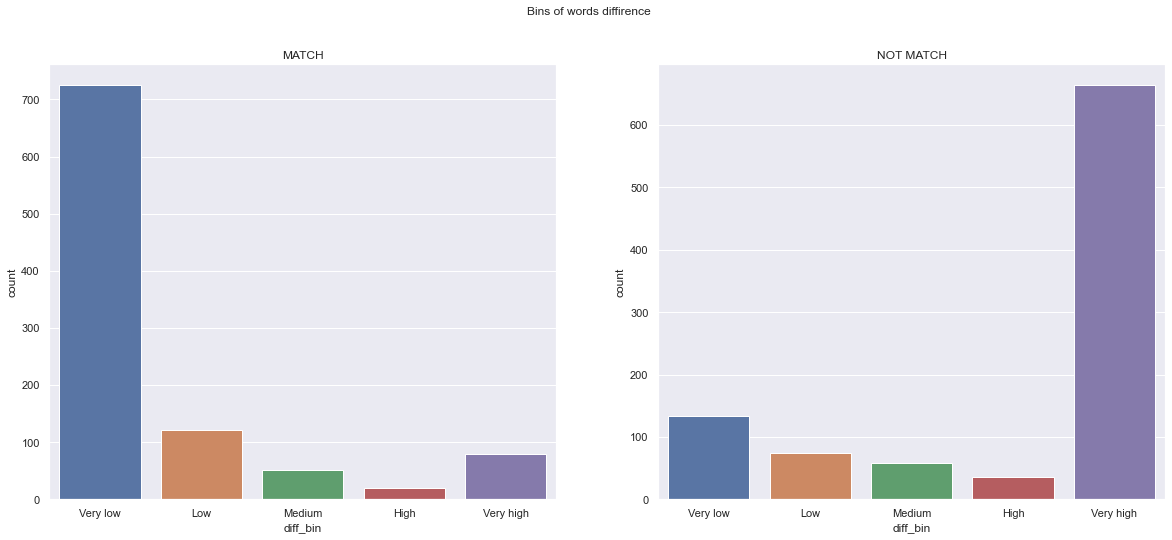

In [13]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_pos['diff_bin'])
plt.title('MATCH')
plt.subplot(122)
sb.countplot(df_neg['diff_bin'])
plt.title('NOT MATCH')
plt.suptitle('Bins of words diffirence');

In [14]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [15]:
def jaccard_search(query, data, top_result = 5, check_time = True):
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0=time()
    results = pd.DataFrame(columns=['lookup_text', 'question_text', 'j_score', 
                                    'jc_word_count_question', 'jc_diff_bin', 'jc_image'])
    
    q = clean_function(query)
    words_doc1 = set(q.lower().split()) 
    
    for i in range(data.shape[0]):
        words_doc2 = set(data.iloc[i]['clean_question'].lower().split())

        # Find the intersection of words list of doc1 & doc2
        intersection = words_doc1.intersection(words_doc2)

        # Find the union of words list of doc1 & doc2
        union = words_doc1.union(words_doc2)

        # Calculate Jaccard similarity score 
        # using length of intersectioEm n set divided by length of union set
        jaccard_score = len(intersection) / len(union)
        result = pd.DataFrame({'lookup_text': query,
                               'question_text': [data.iloc[i]['Question Text']],
                               'j_score': jaccard_score,
                               'jc_word_count_question': [data.iloc[i]['word_count_question']],
                               'jc_diff_bin': [data.iloc[i]['diff_bin']],
                               'jc_image': [data.iloc[i]['Question Image']]})
        results = pd.concat([results,result], axis=0).sort_values('j_score', ascending=False)[:top_result]
    if check_time:
        print('Time:',time()-t0)
    return results

# 2. Jaccard search in NOT MATCH Dataset

In [16]:
results_neg = pd.DataFrame(columns = ['lookup_text', 'question_text', 'j_score', 
                                      'jc_word_count_question', 'jc_diff_bin', 'jc_image'])

queries = df_neg['Lookup Text']

t0 = time()
for q in queries:
    results = jaccard_search(q, df_neg, check_time = False).head(1)
    results_neg = pd.concat([results_neg, results], axis = 0)
print('Jaccard search took: {:.2f} minutes.'.format((time() - t0) / 60))

Jaccard search took: 28.96 minutes.


In [17]:
results_neg.reset_index(drop = True, inplace = True)

df_neg['search_result'] = results_neg['question_text']
df_neg['jc_score'] = results_neg['j_score']
df_neg['jc_word_count_question'] = results_neg['jc_word_count_question']
df_neg['jc_diff_bin'] = results_neg['jc_diff_bin']
df_neg['jc_image'] = results_neg['jc_image']

In [18]:
mask3 = df_neg['Lookup Text'] != df_neg['search_result']

df_check_neg = df_neg[mask3]
df_check_neg.shape

(947, 24)

In [19]:
def check_wrong_results_neg(indices):
    index_ = df_check_neg.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = jaccard_search(df_check_neg.iloc[num]['Lookup Text'], df_check_neg, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_neg.iloc[num]['Lookup Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

In [20]:
top5_result_neg, no_result_neg = check_wrong_results_neg(list(range(0, len(df_check_neg.index))))

In [21]:
print(len(top5_result_neg))
print(len(no_result_neg))

0
947


In [22]:
mask4 = df_neg['Lookup Text'] == df_neg['search_result']

df_match_neg = df_neg[mask4]
df_match_neg.shape

(19, 24)

In [23]:
df_top5_neg = df_neg.iloc[top5_result_neg, :]
df_top5_neg.shape

(0, 24)

In [24]:
df_no_neg = df_neg.iloc[no_result_neg, :]
df_no_neg.shape

(947, 24)

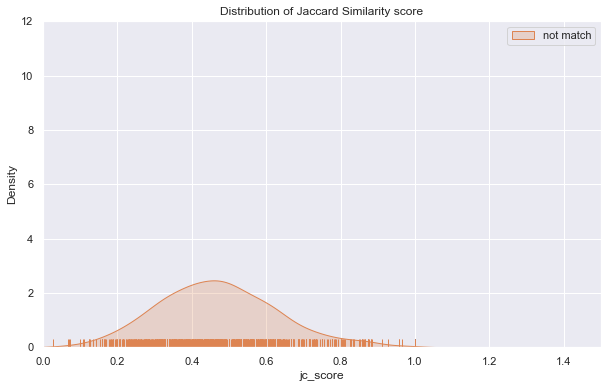

In [25]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_neg.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
plt.ylim([0, 12])
plt.legend()
plt.title('Distribution of Jaccard Similarity score');

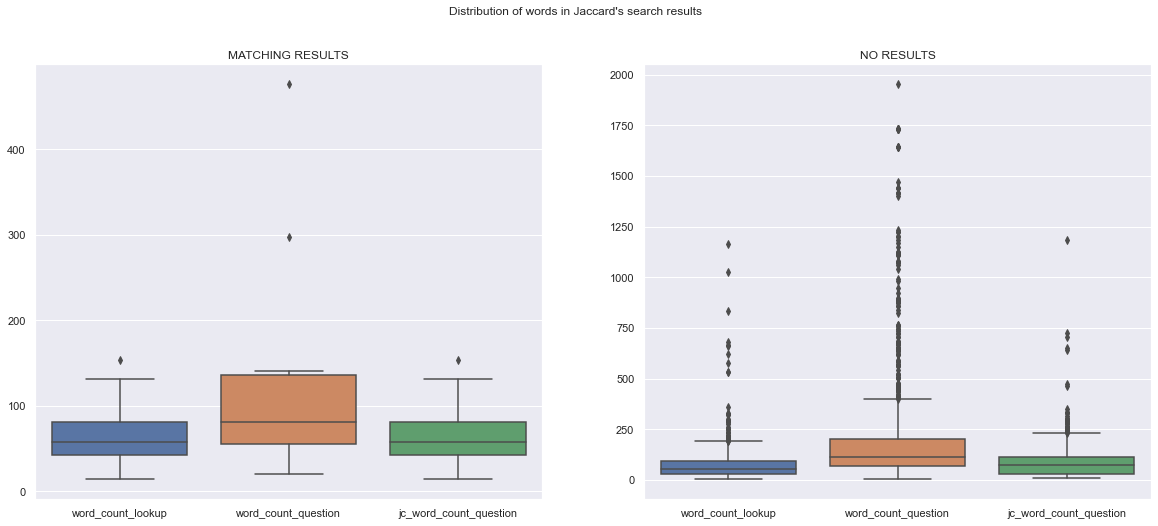

In [26]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_neg[['word_count_lookup', 'word_count_question', 'jc_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_neg[['word_count_lookup', 'word_count_question', 'jc_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Jaccard's search results");

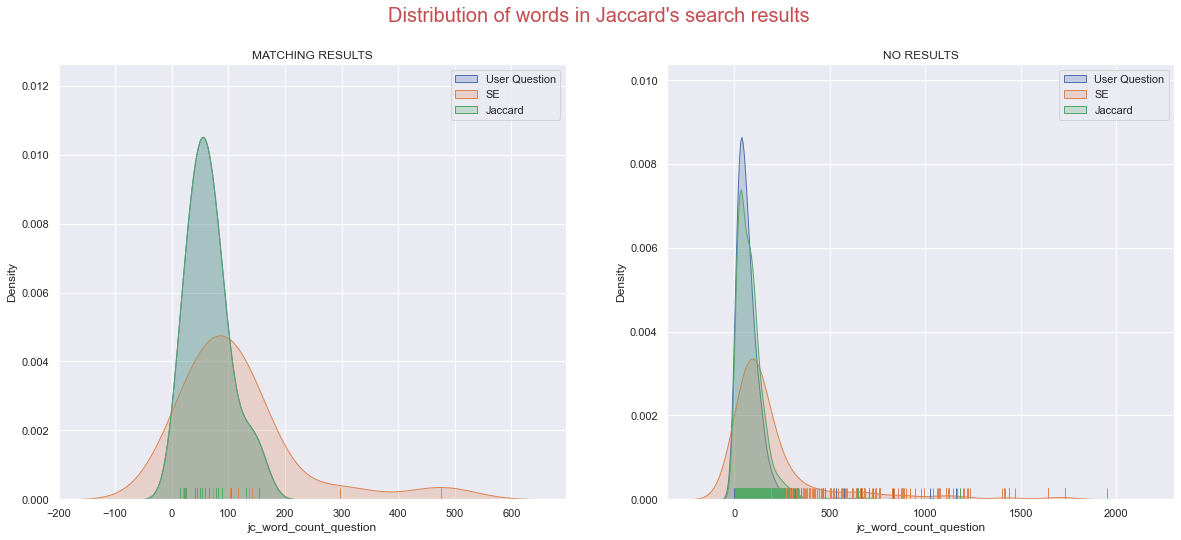

In [27]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_neg.jc_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Jaccard")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_neg.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_neg.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_neg.jc_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Jaccard")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Jaccard's search results", fontsize = 20, color = 'r')
plt.show()

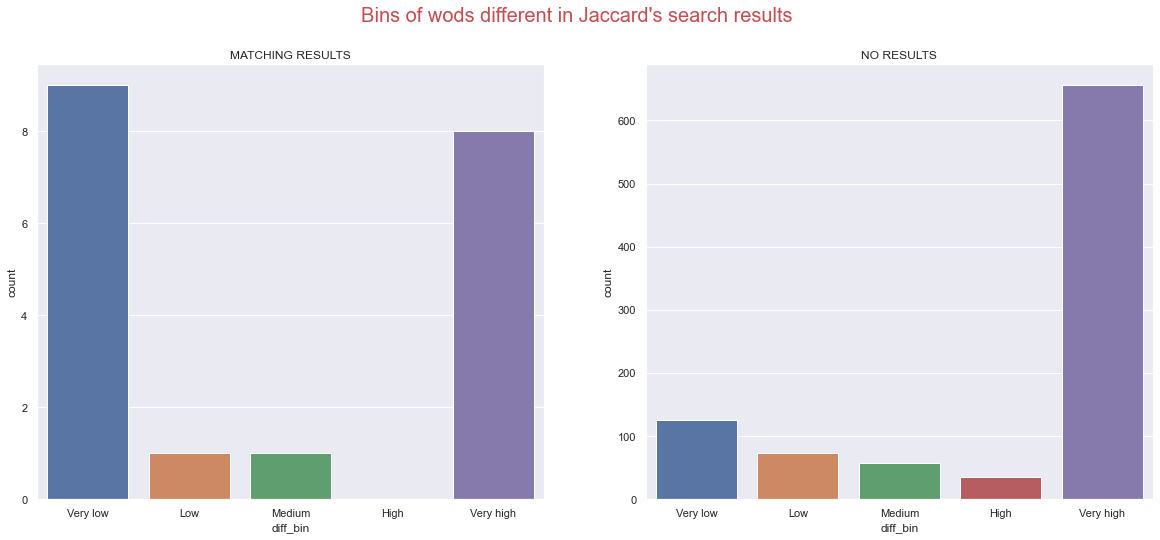

In [28]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_neg['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_neg['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Jaccard's search results", fontsize = 20, color = 'r');

# 3. Jaccard search in MATCH Dataset

In [29]:
results_pos = pd.DataFrame(columns = ['lookup_text', 'question_text', 'j_score', 
                                      'jc_word_count_question', 'jc_diff_bin', 'jc_image'])

queries = df_pos['Lookup Text']

t0 = time()
for q in queries:
    results = jaccard_search(q, df_pos, check_time = False).head(1)
    results_pos = pd.concat([results_pos, results], axis = 0)
print('Jaccard search took: {:.2f} minutes.'.format((time() - t0) / 60))

Jaccard search took: 32.98 minutes.


In [30]:
results_pos.reset_index(drop = True, inplace = True)

df_pos['search_result'] = results_pos['question_text']
df_pos['jc_score'] = results_pos['j_score']
df_pos['jc_word_count_question'] = results_pos['jc_word_count_question']
df_pos['jc_diff_bin'] = results_pos['jc_diff_bin']
df_pos['jc_image'] = results_pos['jc_image']

In [31]:
mask4 = df_pos['Question Text'] != df_pos['search_result']

df_check_pos = df_pos[mask4]
df_check_pos.shape

(39, 24)

In [68]:
def check_wrong_results_pos(indices):
    index_ = df_check_pos.index.tolist()
    no_results = []
    top5_results = []
    for num in indices:
        df_results = jaccard_search(df_check_pos.iloc[num]['Lookup Text'], df_pos, check_time = False)
        top_results = df_results['question_text'].values
        if (df_check_pos.iloc[num]['Lookup Text'] in top_results) or (df_check_pos.iloc[num]['Question Text'] in top_results):
            top5_results.append(index_[num])
        else:
            no_results.append(index_[num])
    return top5_results, no_results

top5_result_pos, no_result_pos = check_wrong_results_pos(list(range(0, len(df_check_pos.index))))

print(len(top5_result_pos))
print(len(no_result_pos))

34
5


In [69]:
df_check_pos.index

Int64Index([ 43, 103, 131, 136, 157, 225, 271, 272, 287, 311, 333, 367, 370,
            388, 389, 428, 440, 442, 454, 457, 458, 461, 466, 502, 514, 559,
            565, 571, 578, 612, 727, 768, 792, 793, 802, 842, 864, 881, 938],
           dtype='int64')

In [70]:
mask6 = df_pos['Question Text'] == df_pos['search_result']

df_match_pos = df_pos[mask6]
df_match_pos.shape

(957, 24)

In [71]:
df_top5_pos = df_pos.iloc[top5_result_pos, :]
df_top5_pos.shape

(34, 24)

In [72]:
df_no_pos = df_pos.iloc[no_result_pos, :]
df_no_pos.shape

(5, 24)

In [73]:
df_no_pos

,Feedback ID,Lookup Text,Question Text,Feedback Type,Feedback Result,Human Feedback,Lookup Image,Question Image,index_org,clean_lookup,...,char_count_question,word_count_question,average_word_length_question,diff_word,diff_bin,search_result,jc_score,jc_word_count_question,jc_diff_bin,jc_image
454,6723.0,\( b_{Q_{h}^{h}} \) 7. Tìm \( x \) và y trên h...,"Tim x va y tren hinh 21 , biêt rång \( ABCD \)...",POSITIVE,SKIP,MATCH,https://s3.icankid.io/uploads/question/2dd1527...,https://s3.icankid.io/uploads/question/bcc04a4...,857,\ ( b_ { q_ { h }_^_{ h }_}_\ ) 7 . tìm \ ( x ...,...,117,40,2.925000,5,Very low,"22 Hình thang \( A B C D \) có đáy \( A B, C D...",0.25,105,High,https://s3.icankid.io/uploads/question/6530247...
457,6742.0,\( B \dot{a} 21 \) duing theigg \( y=2 x-2018 \),Ба7 \( 2.21 \)\na) Xảc dịnh hệ số \( a \) và b...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/4ba3b92...,https://s3.icankid.io/uploads/question/3094e8e...,862,\ ( b \ dot { a } 21 \ ) duing theigg \ ( y_=_...,...,207,63,3.285714,44,Very high,"a) \( \frac{-1}{6}+0,75 \)",0.315789,16,Very low,https://s3.icankid.io/uploads/question/b2db549...
514,7028.0,a) \( \sqrt{2 x-1}=7 \),Bài 4: (2 điểm) Giải các phương trình sau :\na...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/1a4e75c...,https://s3.icankid.io/uploads/question/eb3b8a9...,960,a ) \ ( \_sqrt { 2 x-1 } = 7_\ ),...,126,45,2.800000,33,Very high,a) \( (2 x-1) \cdot(x+2) \),0.428571,16,Very low,https://s3.icankid.io/uploads/question/fdef44f...
792,8705.0,Che \( \sin \alpha+\cos \alpha=a \). Tint \( \...,2: Cho biết \( \sin \alpha+\cos \alpha=a \). G...,NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/0cf6296...,https://s3.icankid.io/uploads/question/8894d0e...,1574,che \ ( \ sin \ alpha + \ cos \ alpha = a \ ) ...,...,408,135,3.022222,104,Very high,\( 8 \sin 2 x-\cos 2 x+3 \sin x-\cos x-1=0 \),0.368421,23,Very low,https://s3.icankid.io/uploads/question/0cf2c5b...
802,8751.0,(1) Ve chising thang sautren aing 1 he thuc ta...,"Câu 15. \( (1,5 \) diểm).\na) Vẽ dổ thị của ha...",NEGATIVE,MATCH,MATCH,https://s3.icankid.io/uploads/question/da8811b...,https://s3.icankid.io/uploads/question/8d65716...,1590,( 1 ) ve chising thang sautren aing 1 he thuc ...,...,262,85,3.082353,13,Medium,26. Tính :\na) \( \left(2 x^{2}+3 y\right)^{3}...,0.340909,47,Very low,https://s3.stag.icankids.com.vn/uploads/questi...


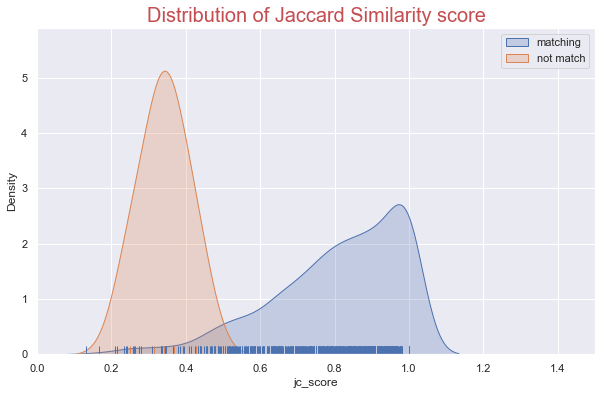

In [74]:
plt.figure(figsize=(10,6))
sb.distplot(df_match_pos.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Distribution of Jaccard Similarity score', fontsize = 20, color = 'r');

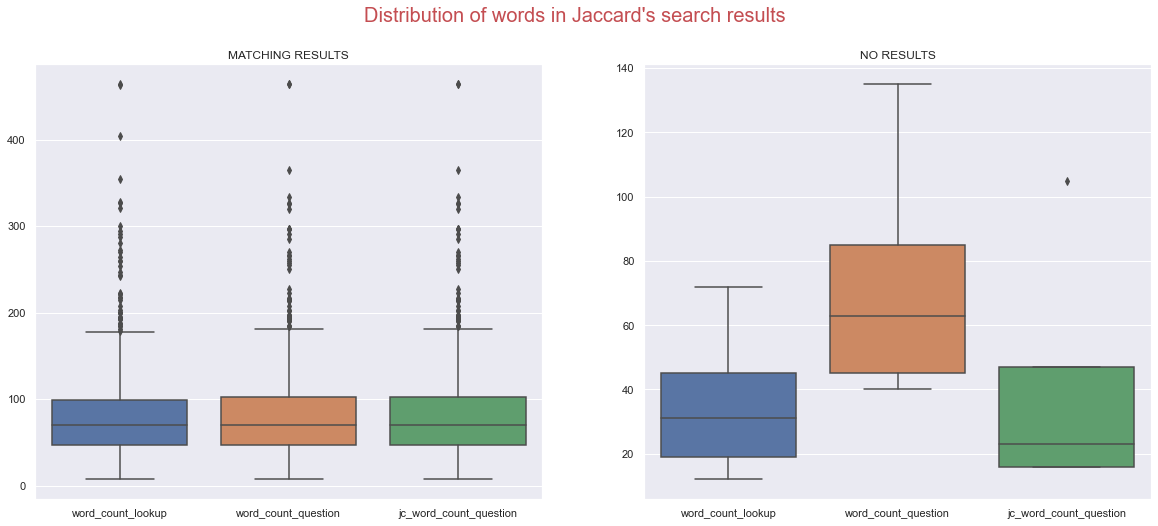

In [75]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.boxplot(data = df_match_pos[['word_count_lookup', 'word_count_question', 'jc_word_count_question']])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.boxplot(data = df_no_pos[['word_count_lookup', 'word_count_question', 'jc_word_count_question']])
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Jaccard's search results", fontsize = 20, color = 'r');

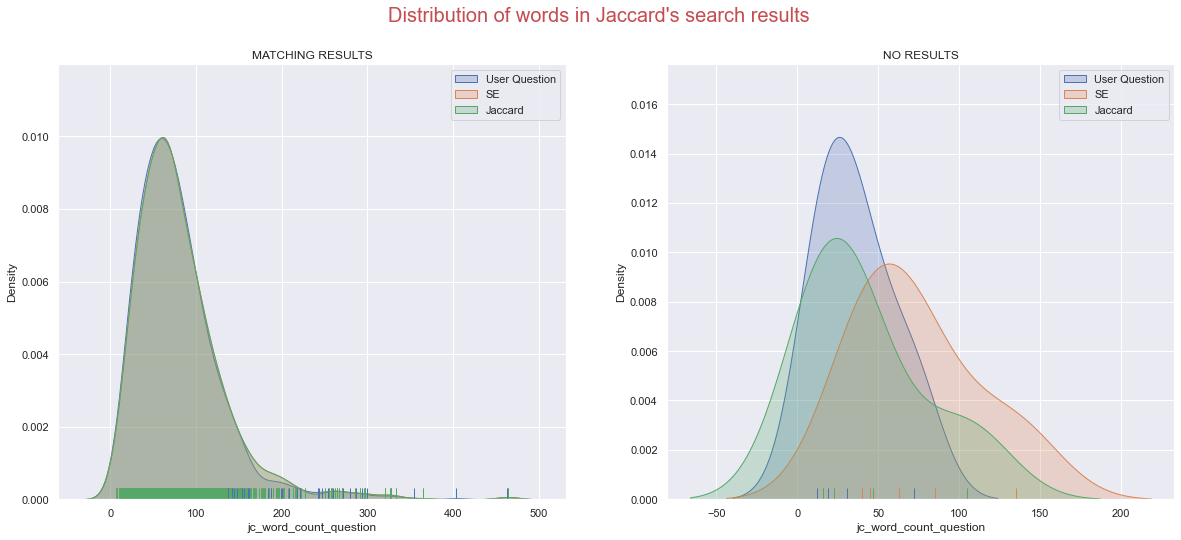

In [76]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.distplot(df_match_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "User Question")
sb.distplot(df_match_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "SE")
sb.distplot(df_match_pos.jc_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'}, label = "Jaccard")
plt.legend()
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.distplot(df_no_pos.word_count_lookup, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "User Question")
sb.distplot(df_no_pos.word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "SE")
sb.distplot(df_no_pos.jc_word_count_question, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "Jaccard")
plt.legend()
plt.title('NO RESULTS')
plt.suptitle("Distribution of words in Jaccard's search results", fontsize = 20, color = 'r')
plt.show()

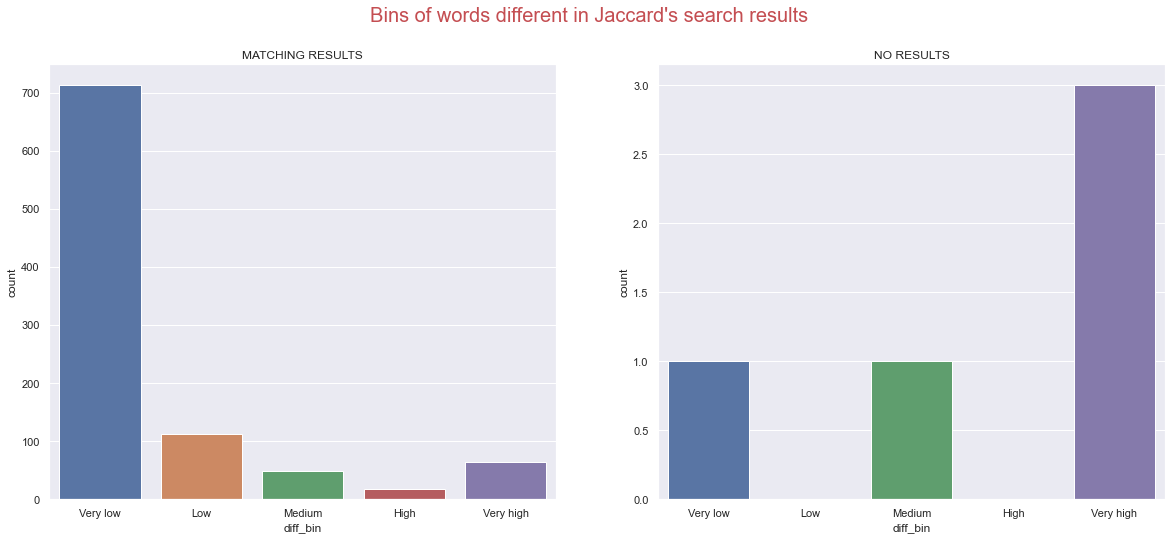

In [77]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match_pos['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_no_pos['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of words different in Jaccard's search results", fontsize = 20, color = 'r');

# 4. Comparing

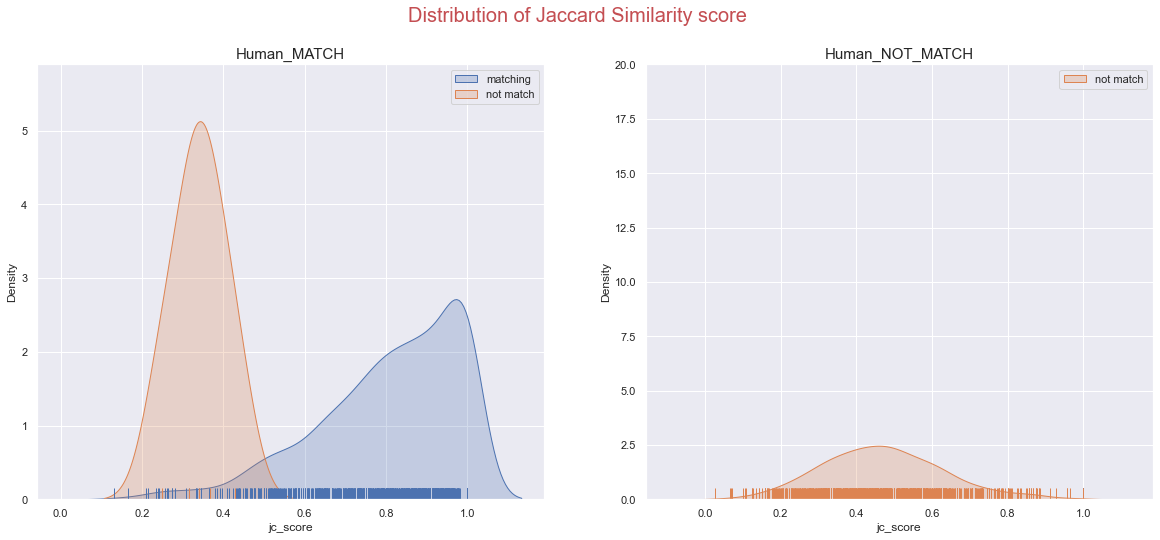

In [78]:
plt.figure(figsize=(20,8))
plt.subplot(121)
sb.distplot(df_match_pos.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_pos.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
# plt.xlim([0, 1.5])
# plt.ylim([0, 12])
plt.legend()
plt.title('Human_MATCH', fontsize = 15)
plt.subplot(122)
sb.distplot(df_match_neg.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
# sb.distplot(df_top5_neg.jc_score, label = 'top5_relevance')
sb.distplot(df_no_neg.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = "not match")
# plt.xlim([0, 1.5])
plt.ylim([0, 20])
plt.legend()
plt.title('Human_NOT_MATCH', fontsize = 15)
plt.suptitle('Distribution of Jaccard Similarity score', fontsize = 20, color = 'r')
plt.show()

In [79]:
df_final = pd.DataFrame({'Group': ['Human_MATCH', 'Human_NOT_MATCH'],
                         'Matching': [df_match_pos.shape[0], df_match_neg.shape[0]],
                         'In top5': [df_top5_pos.shape[0], df_top5_neg.shape[0]],
                         'No result': [df_no_pos.shape[0], df_no_neg.shape[0]]})
df_final

,Group,Matching,In top5,No result
0,Human_MATCH,957,34,5
1,Human_NOT_MATCH,19,0,947


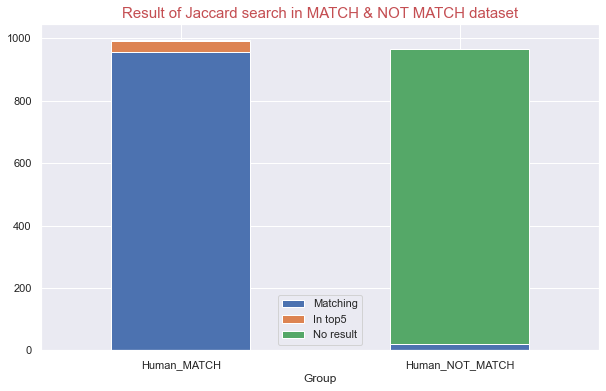

In [80]:
plt.rcParams["figure.figsize"] = [10, 6]
df_final.plot.bar(x = 'Group', stacked = True, rot = 0)
plt.legend()
plt.title('Result of Jaccard search in MATCH & NOT MATCH dataset', fontsize = 15, color = 'r');

In [85]:
df_no_pos = df_no_pos.sort_values(by = 'jc_score', ascending = False)

PAIRS: 1 - Jaccard score: 0.42857142857142855
-- Number of words: 12


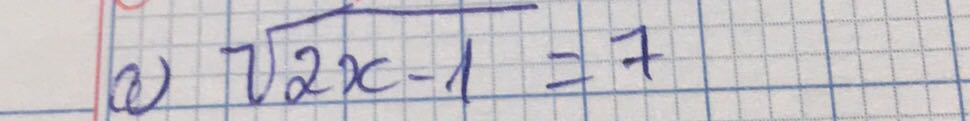

-- Number of words: 45


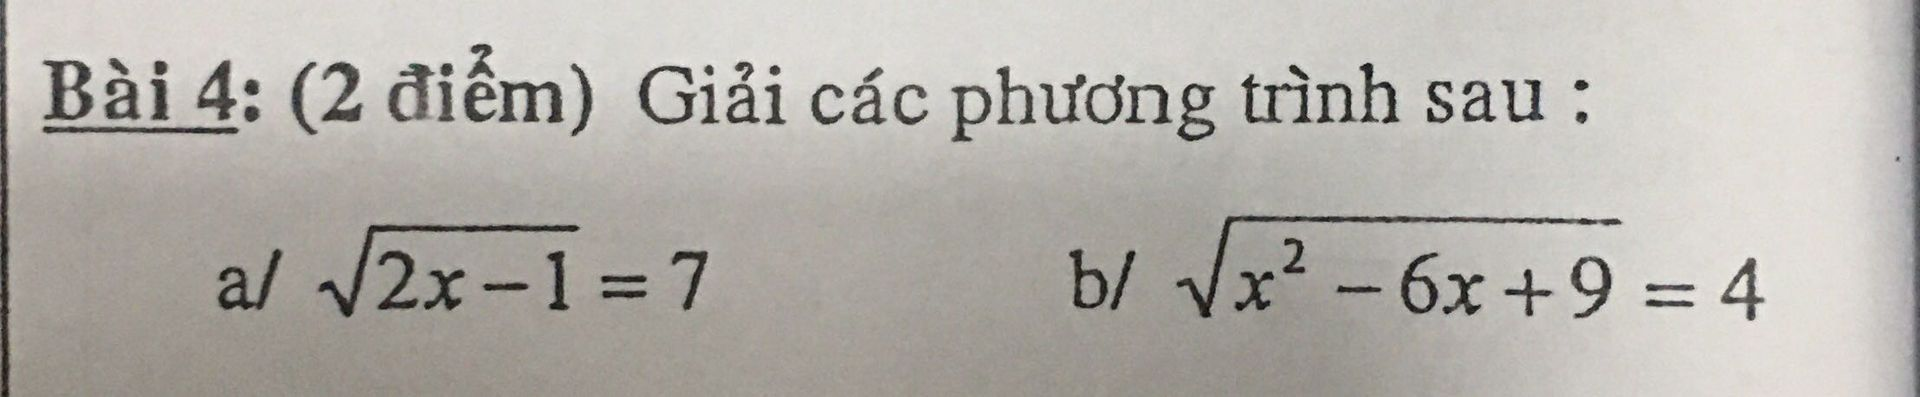

-- Number of words: 16


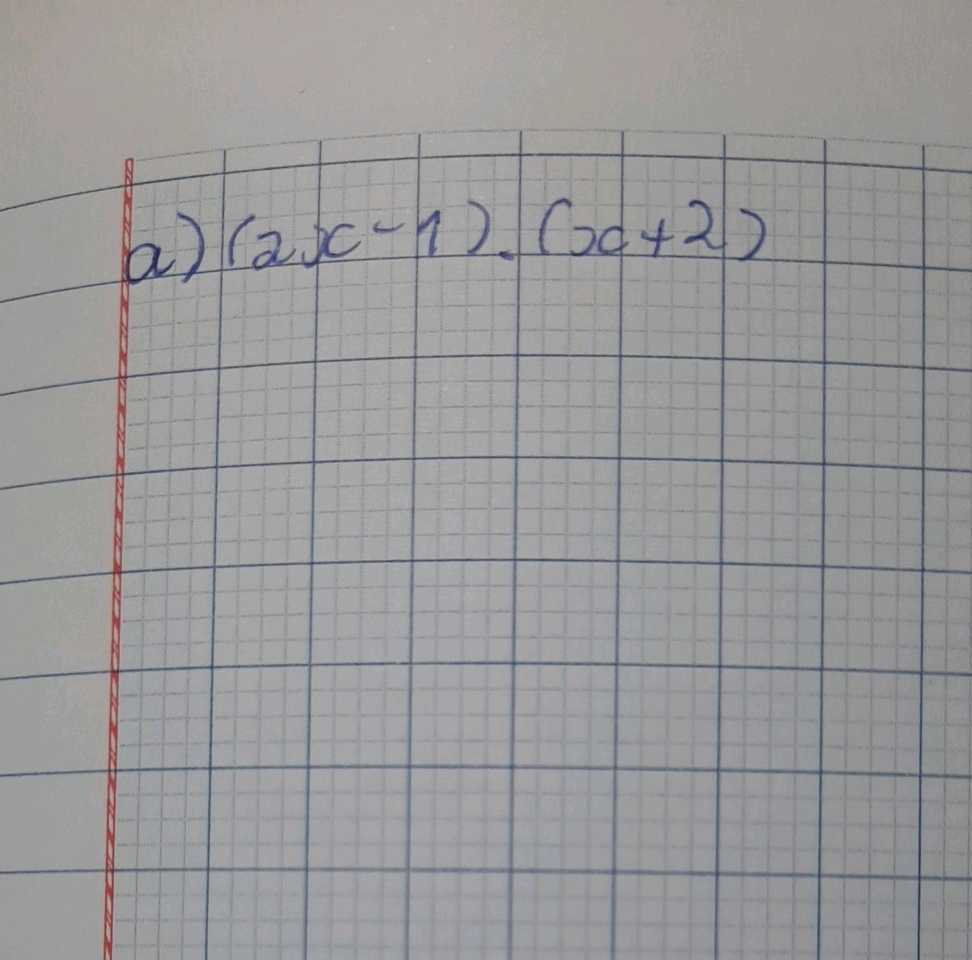

************

PAIRS: 2 - Jaccard score: 0.3684210526315789
-- Number of words: 31


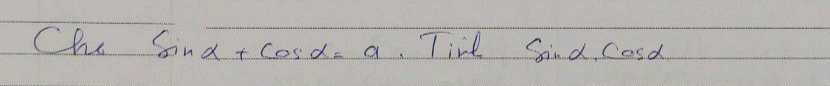

-- Number of words: 135


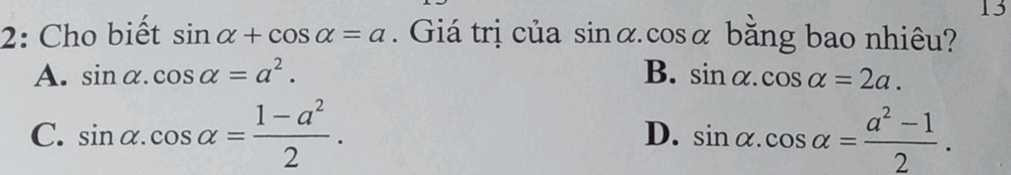

-- Number of words: 23


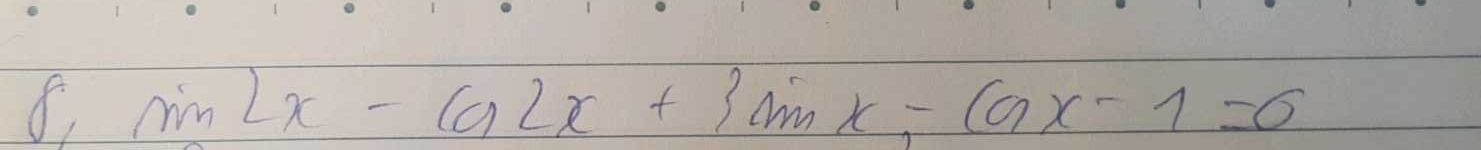

************

PAIRS: 3 - Jaccard score: 0.3409090909090909
-- Number of words: 72


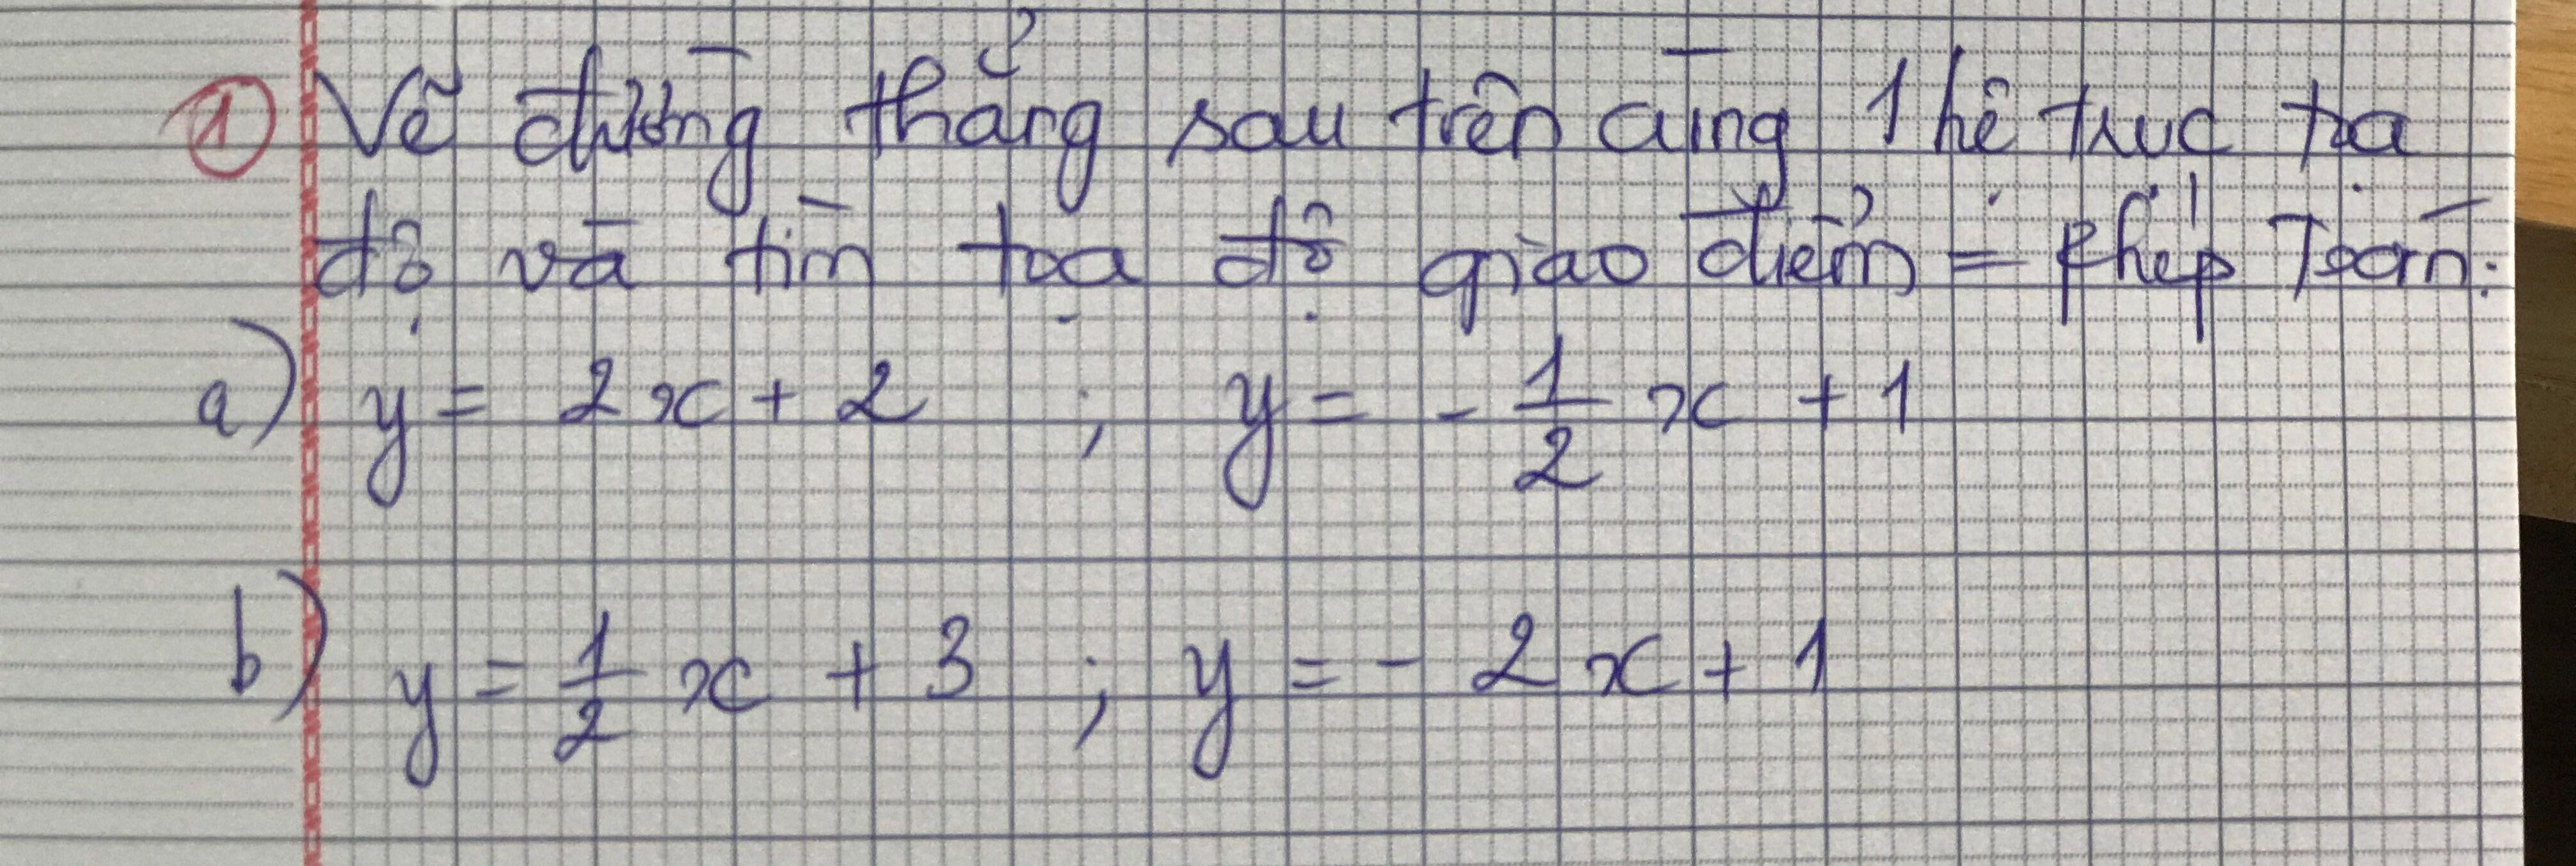

-- Number of words: 85


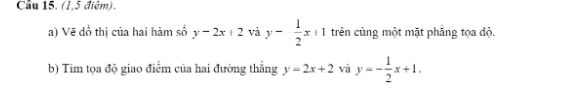

-- Number of words: 47


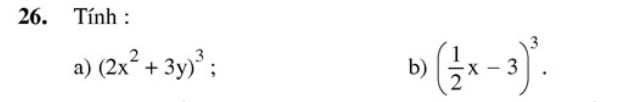

************

PAIRS: 4 - Jaccard score: 0.3157894736842105
-- Number of words: 19


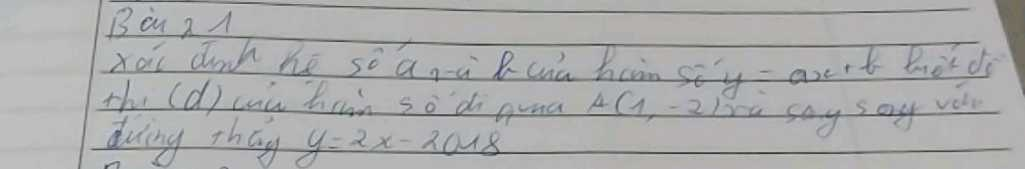

-- Number of words: 63


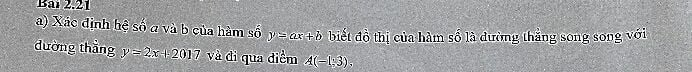

-- Number of words: 16


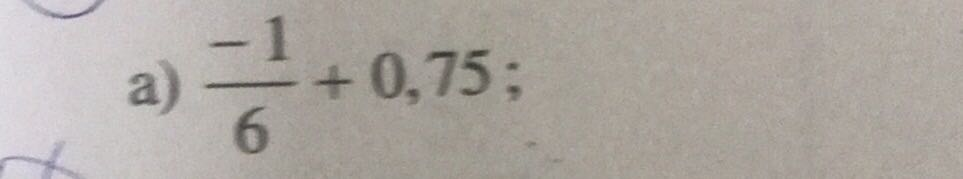

************

PAIRS: 5 - Jaccard score: 0.25
-- Number of words: 45


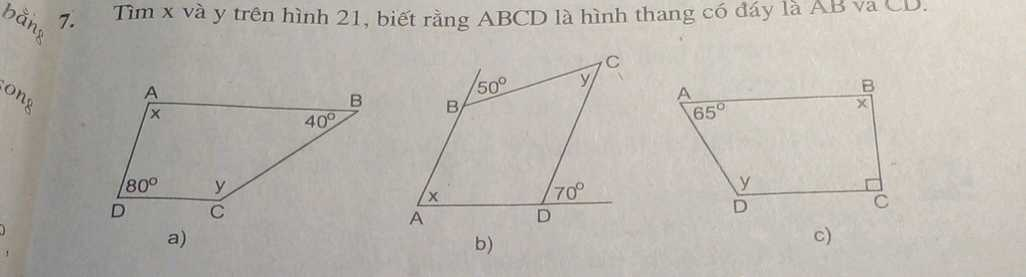

-- Number of words: 40


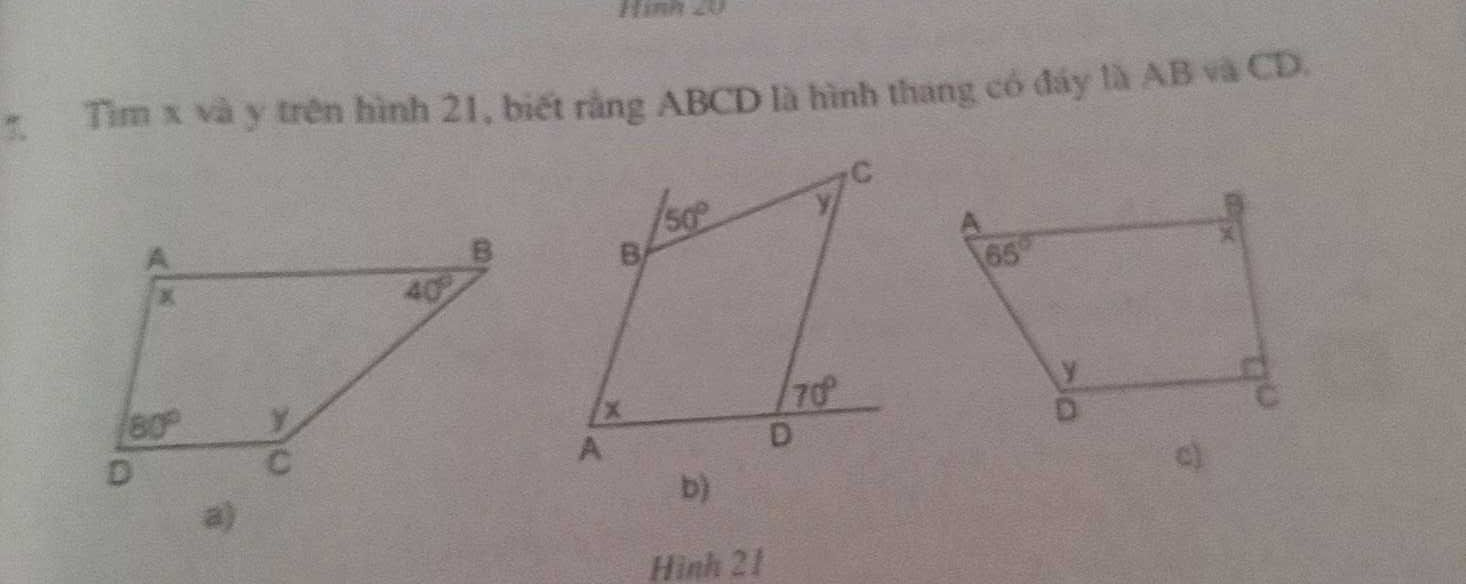

-- Number of words: 105


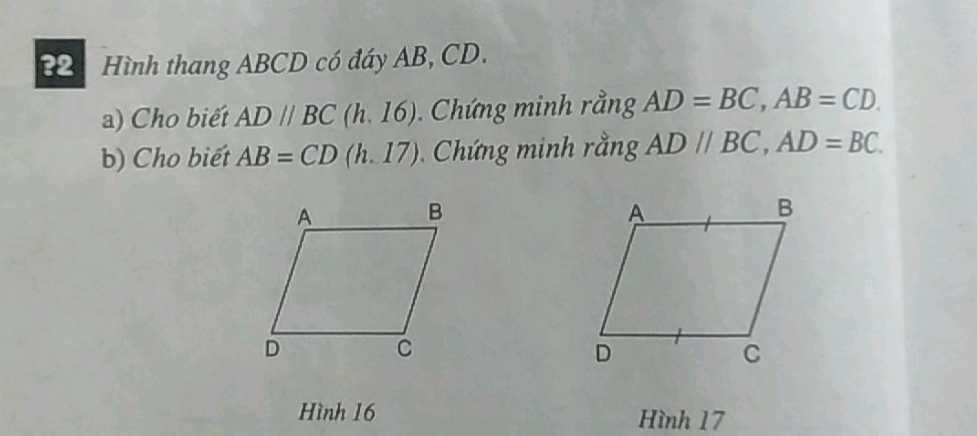

************



In [86]:
idx = 0
for url1, url2 in zip(df_no_pos['Question Image'].values, df_no_pos['jc_image'].values):
    print('PAIRS: {} - Jaccard score: {}'.format(idx + 1, df_no_pos['jc_score'].values[idx]))
    print('-- Number of words:', df_no_pos['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_no_pos['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_no_pos['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_no_pos['jc_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    print()
    idx += 1